# Radial Metallicity Gradients in NIHAO and GALAH


This script traces the face on position and iron abundance [Fe/H] of some of the youngest stars in a NIHAO simulation. It also overlays them on top of the gas density. To do so, it reads in the lite files of galaxy simulations from NIHAO and then performs.  

*How much does this picture deviate from a simple toy model of a linear Radius-[Fe/H] gradient and what can we learn about the real Milky Way?*


#### Github Repository

https://www.github.com/svenbuder/nihao_radial_metallicity_gradients

#### Author:
Sven Buder (ANU, sven.buder@anu.edu.au)

#### GALAH DR3:
Buder et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.506..150B

#### Open Cluster Memberships:
Cantat-Gaudin et al. (2020): https://ui.adsabs.harvard.edu/abs/2020A&A...633A..99C

#### Initial Data - NIHAO-UHD simulations:  
Buck (2020): https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.5435B  
Buck et al. (2020b): https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.3461B  
Buck et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3365B  
Buck et al. (2023): https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.1565B  
Buder, Mijnarends, and Buck (2024): https://ui.adsabs.harvard.edu/abs/2024arXiv240413835B  

#### Milky Way Spiral Arms and Young Stars:
Hawkins (2023): https://ui.adsabs.harvard.edu/abs/2023MNRAS.525.3318H  
Hackshaw et al. (2024): https://ui.adsabs.harvard.edu/abs/2024arXiv240518120H

In [107]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# general packages
import numpy as np
from astropy.table import Table, join
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import binned_statistic_2d

# astropy
import astropy.units as u
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

panels = [
    'a)','b)','c)',
    'd)','e)','f)',
    'g)','h)','i)',
    'j)','k)','l)',
    'm)','n)','o)',
    'q)','r)','s)',
    't)','u)','v)',
    'w)','x)','y)',
    'z)','aa)','ab)',
    'ac)','ad)','ae)'
]

# 2. Data

## 2.1 Observations

In [ ]:
# GALAH DR3 (Buder et al., 2021)
galah_dr3_main     = Table.read('data/GALAH_DR3_main_allstar_v2.fits')
galah_dr3_dynamics = Table.read('data/GALAH_DR3_VAC_dynamics_v2.fits')
galah_dr3 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id',metadata_conflicts='silent')
galah_dr3 = galah_dr3[~galah_dr3['dr2_source_id'].mask]
galah_dr3['e_R_Rzphi'] = 0.5/1.645*(galah_dr3['R_Rzphi_95'] - galah_dr3['R_Rzphi_5']) # 5th-95th cover 2sigma * 1.645
galah_dr3['e_z_Rzphi'] = 0.5/1.645*(galah_dr3['z_Rzphi_95'] - galah_dr3['z_Rzphi_5']) # convert to 1 sigma
galah_dr3 = galah_dr3[(
    (galah_dr3['flag_sp'] == 0) &
    (galah_dr3['flag_fe_h'] == 0)
)]
galah_dr3 = galah_dr3[['dr2_source_id','fe_h','e_fe_h','R_Rzphi','e_R_Rzphi','z_Rzphi','e_z_Rzphi']]


In [ ]:
# APOGEE DR17 (SDSS Collaboration et al., 2022)
apogee_dr17 = Table.read('data/allStar-dr17-synspec_rev1.fits',1)
apogee_dr17['dr2_source_id'] = apogee_dr17['GAIAEDR3_SOURCE_ID']
apogee_dr17 = apogee_dr17[(
    (apogee_dr17['ASPCAPFLAG'] < 2**23) &
    (apogee_dr17['FE_H_FLAG'] == 0)
)]
apogee_dr17 = apogee_dr17[['dr2_source_id','RA','GAIAEDR3_PMRA','DEC','GAIAEDR3_PMDEC','GAIAEDR3_R_MED_PHOTOGEO','VHELIO_AVG','FE_H','FE_H_ERR','FE_H_FLAG',]]
# rename some keywords
apogee_dr17.rename_column('FE_H','fe_h')
apogee_dr17.rename_column('FE_H_ERR','e_fe_h')

In [ ]:
# Cantat-Gaudin et al. (2020) Open Cluster Membership Catalogue
cg20 = Table.read('data/CantatGaudin_2020_AandA_640_1.fits')
cg20['dr2_source_id'] = cg20['GaiaDR2']
cg20 = cg20[~cg20['logAge'].mask]

In [ ]:
# Open Cluster Members in GALAH DR3
oc_galah_dr3 = join(cg20, galah_dr3, keys = 'dr2_source_id')

# Open Cluster Members in GALAH DR3
oc_apogee_dr17 = join(cg20, apogee_dr17, keys = 'dr2_source_id')

In [ ]:
unique_oc_galah_dr3, unique_oc_galah_dr3_index = np.unique(oc_galah_dr3['Cluster'], return_index=True)

oc_galah_dr3_unique = Table()
oc_galah_dr3_unique['Cluster'] = unique_oc_galah_dr3
oc_galah_dr3_unique['Age_Myr'] = 10**(oc_galah_dr3['logAge'][unique_oc_galah_dr3_index]-6)

for key_index, key in enumerate(['R_Rzphi','z_Rzphi','fe_h']):
    
    values_median = []
    values_scatter = []
    values_numbers = []
    
    for cluster in unique_oc_galah_dr3:
        
        in_cluster_unflagged = (
            (oc_galah_dr3['Cluster'] == cluster)
        )
        
        if len(oc_galah_dr3[key][in_cluster_unflagged]) > 3:
            values_median.append(np.median(oc_galah_dr3[key][in_cluster_unflagged]))
            values_scatter.append(
                np.std(oc_galah_dr3[key][in_cluster_unflagged])**2+
                np.median(oc_galah_dr3['e_'+key][in_cluster_unflagged])**2
            )
            if key_index == 0: values_numbers.append(len(oc_galah_dr3[key][in_cluster_unflagged]))
            
        else:
            values_median.append(np.nan)
            values_scatter.append(np.nan)
            if key_index == 0: values_numbers.append(0)
            
    if key_index == 0: oc_galah_dr3_unique['numbers'] = np.array(values_numbers,dtype=int)
    oc_galah_dr3_unique[key+'_median'] = np.array(values_median,dtype=np.float32)
    oc_galah_dr3_unique[key+'_scatter'] = np.array(values_scatter,dtype=np.float32)

oc_galah_dr3_unique = oc_galah_dr3_unique[np.isfinite(oc_galah_dr3_unique['R_Rzphi_median'])]
oc_galah_dr3_unique.sort('z_Rzphi_median')
oc_galah_dr3_unique[oc_galah_dr3_unique['Age_Myr'] < 1000]

In [ ]:
# First we need to calculate R, phi, and Z from APOGEE ra, dec, and D.

# galpy
import galpy
#from galpy.potential import MWPotential2014 as pot
from galpy.potential.mwpotentials import McMillan17 as pot
from galpy.actionAngle import actionAngleStaeckel, actionAngleSpherical
from galpy.orbit import Orbit

# Reference values
#r_galactic_centre = 8.178*u.kpc # Gravity Collaboration, 2019, A&A, 625, 10
r_galactic_centre = 8.21*u.kpc # McMillan Potential, 2017
z_galactic_plane = 25.0*u.pc # Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529

print('Reference frame:')
print('R_GC = '+str(r_galactic_centre)+' (McMillan, 2017, MNRAS, 465, 76)')
print('phi_GC = '+str(0*u.rad))
print('z_GC = '+str(z_galactic_plane)+' (Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529)')

v_total_sun = (np.tan(6.379*u.mas)*r_galactic_centre/u.yr).to(u.km/u.s) # pm_l by Reid & Brunthaler 2004, ApJ, 616, 872
print('V_total_sun: = '+"{:.2f}".format(v_total_sun)+' (Reid & Brunthaler 2004, ApJ, 616, 872)')
v_peculiar = [11.1, 15.17, 7.25]*u.km/u.s # U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829, V so that V = V_total-V_sun
print('V_peculiar = ',(v_peculiar),' (U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829)')
print('V-component of V_peculiar = 15.17 km/s, instead of 12.24 km/s by Schoenrich et al. (2010), for matching v_circular')
v_circular = np.round(v_total_sun-v_peculiar[1],1)
print('V_circular = ',"{:.2f}".format(v_circular),' (McMillan, 2017, MNRAS, 465, 76)')


In [ ]:
ra     = list(oc_apogee_dr17['RA']) * u.deg
dec    = list(oc_apogee_dr17['DEC']) * u.deg
dist   = list(oc_apogee_dr17['r_med']) * u.pc
pm_ra  = list(oc_apogee_dr17['GAIAEDR3_PMRA']) * u.mas/u.yr
pm_dec = list(oc_apogee_dr17['GAIAEDR3_PMDEC']) * u.mas/u.yr
v_los  = list(oc_apogee_dr17['VHELIO_AVG']) * u.km/u.s

o = Orbit(
        vxvv=[ra,dec,dist,pm_ra, pm_dec,v_los],
        ro=r_galactic_centre,
        vo=v_circular,
        zo=z_galactic_plane,
        solarmotion=[-11.1, 15.17, 7.25]*u.km/u.s,
        radec=True
    )

oc_apogee_dr17['R_Rzphi'] = o.R()*u.kpc
oc_apogee_dr17['z_Rzphi'] = o.z()*u.kpc
oc_apogee_dr17['e_R_Rzphi'] = 0.00 * np.ones(len(oc_apogee_dr17['R_Rzphi']))
oc_apogee_dr17['e_z_Rzphi'] = 0.00 * np.ones(len(oc_apogee_dr17['R_Rzphi']))

unique_oc_apogee_dr17, unique_oc_apogee_dr17_index = np.unique(oc_apogee_dr17['Cluster'], return_index=True)

oc_apogee_dr17_unique = Table()
oc_apogee_dr17_unique['Cluster'] = unique_oc_apogee_dr17
oc_apogee_dr17_unique['Age_Myr'] = 10**(oc_apogee_dr17['logAge'][unique_oc_apogee_dr17_index]-6)

for key_index, key in enumerate(['R_Rzphi','z_Rzphi','fe_h']):
    
    values_median = []
    values_scatter = []
    values_numbers = []
    
    for cluster in unique_oc_apogee_dr17:
        
        in_cluster_unflagged = (
            (oc_apogee_dr17['Cluster'] == cluster)
        )
        
        if len(oc_apogee_dr17[key][in_cluster_unflagged]) > 3:
            values_median.append(np.median(oc_apogee_dr17[key][in_cluster_unflagged]))
            values_scatter.append(
                np.std(oc_apogee_dr17[key][in_cluster_unflagged])**2+
                np.median(oc_apogee_dr17['e_'+key][in_cluster_unflagged])**2
            )
            if key_index == 0: values_numbers.append(len(oc_apogee_dr17[key][in_cluster_unflagged]))
            
        else:
            values_median.append(np.nan)
            values_scatter.append(np.nan)
            if key_index == 0: values_numbers.append(0)
            
    if key_index == 0: oc_apogee_dr17_unique['numbers'] = np.array(values_numbers,dtype=int)
    oc_apogee_dr17_unique[key+'_median'] = np.array(values_median,dtype=np.float32)
    oc_apogee_dr17_unique[key+'_scatter'] = np.array(values_scatter,dtype=np.float32)

oc_apogee_dr17_unique = oc_apogee_dr17_unique[np.isfinite(oc_apogee_dr17_unique['R_Rzphi_median'])]
oc_apogee_dr17_unique.sort('z_Rzphi_median')
oc_apogee_dr17_unique[oc_apogee_dr17_unique['Age_Myr'] < 1000]

## 2.2 NIHAO simulations

In [166]:
sim_stars = Table.read('data/NIHAO_g8.26e11_extensive_stars.fits')
sim_gas   = Table.read('data/NIHAO_g8.26e11_extensive_gas.fits')

sim_stars['R'] = np.sqrt(sim_stars['x']**2 + sim_stars['y']**2)
sim_stars['phi'] = np.arctan2(sim_stars['y'], sim_stars['x'])
sim_stars['phi_angle'] = sim_stars['phi'] * 180/np.pi + 180
sim_gas['R'] = np.sqrt(sim_gas['x']**2 + sim_gas['y']**2)

# Adjust [Fe/H] to be solar for 4.5+-0.5Gyr and R=8.2+-0.2kpc
sim_solar_type = (
    (np.abs(sim_stars['R'] - 8.21) < 0.5) &
    (np.abs(sim_stars['age'] - 4.5) < 0.5)
)
for key in sim_stars.keys():
    if key[-2:] == '_H':
        sim_stars[key] -= np.median(sim_stars[key][sim_solar_type])

# 3 Radius Metallicity Gradients

In [ ]:
def plot_radius_metallicity_gradient(maximum_age_myr = 1000, z_max_pc = 2000):

    f, gs = plt.subplots(1,3,figsize=(12,4),sharey=True)

    ax = gs[0]
    ax.text(0.04,0.95,panels[0]+' Open Clusters Milky Way',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{gal}~/~\mathrm{kpc}$')
    ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

    galah_subset = (
        (oc_galah_dr3_unique['Age_Myr'] < maximum_age_myr) &
        (np.abs(oc_galah_dr3_unique['z_Rzphi_median']) < z_max_pc / 1000.)
    )

    ax.errorbar(
        oc_galah_dr3_unique['R_Rzphi_median'][galah_subset],
        oc_galah_dr3_unique['fe_h_median'][galah_subset],
        yerr = oc_galah_dr3_unique['fe_h_scatter'][galah_subset],
        c = 'k', fmt = '.', lw = 0.2,
        zorder = 1
    )
    
    s = ax.scatter(
        oc_galah_dr3_unique['R_Rzphi_median'][galah_subset],
        oc_galah_dr3_unique['fe_h_median'][galah_subset],
        c = oc_galah_dr3_unique['Age_Myr'][galah_subset],
        s = 50, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 2, label = 'GALAH DR3', cmap='RdYlBu'
    )
    
    apogee_subset = (
        (oc_apogee_dr17_unique['Age_Myr'] < maximum_age_myr) &
        (np.abs(oc_apogee_dr17_unique['z_Rzphi_median']) < z_max_pc / 1000.)
    )

    ax.errorbar(
        oc_apogee_dr17_unique['R_Rzphi_median'][apogee_subset],
        oc_apogee_dr17_unique['fe_h_median'][apogee_subset],
        yerr = oc_apogee_dr17_unique['fe_h_scatter'][apogee_subset],
        c = 'k', fmt = '.', lw = 0.2,
        zorder = 1
    )
    
    s = ax.scatter(
        oc_apogee_dr17_unique['R_Rzphi_median'][apogee_subset],
        oc_apogee_dr17_unique['fe_h_median'][apogee_subset],
        c = oc_apogee_dr17_unique['Age_Myr'][apogee_subset],
        marker = 'X', s = 50, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 2, label = 'APOGEE DR17', cmap='RdYlBu'
    )
    ax.legend(fontsize=10,loc='lower right')
    plt.colorbar(s, ax=ax, label='CG+20 Age / Myr', orientation='horizontal')
    
    ax = gs[1]
    ax.text(0.04,0.95,panels[1]+' Young Star Particles NIHAO',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{gal}~/~\mathrm{kpc}$')
    #ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    #ax.yaxis.set_tick_params(labelleft=True)

    young_star_particles = (
        (sim_stars['age'] < maximum_age_myr/1000.) &
        (sim_stars['R'] > np.min(oc_galah_dr3_unique['R_Rzphi_median'][galah_subset])) &
        (sim_stars['R'] < np.max(oc_galah_dr3_unique['R_Rzphi_median'][galah_subset])) &
        (np.abs(sim_stars['z']) < np.max(z_max_pc / 1000.))
    )
    
    s = ax.scatter(
        sim_stars['R'][young_star_particles],
        sim_stars['Fe_H'][young_star_particles],
        c = sim_stars['age'][young_star_particles] * 1000.,
        s = 10, vmin = 0, vmax = maximum_age_myr, cmap='RdYlBu',
        zorder = 1
    )
    plt.colorbar(s, ax=ax, label='Star Particle Age / Myr', orientation='horizontal')


    ax = gs[2]
    ax.text(0.04,0.95,panels[2]+' Young Star Particles NIHAO',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{gal}~/~\mathrm{kpc}$')
    #ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    #ax.yaxis.set_tick_params(labelleft=True)

    young_star_particles = (
        (sim_stars['age'] < maximum_age_myr/1000.) &
        (sim_stars['R'] < 20.) &
        (sim_stars['z'] < 0.1)
    )

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][young_star_particles], 
        sim_stars['Fe_H'][young_star_particles],
        sim_stars['age'][young_star_particles]*1000, statistic='median',
        bins=100)
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = maximum_age_myr,)
    plt.colorbar(pcm, ax=ax, label='Median Star Particle Age / Myr', orientation='horizontal')

    plt.tight_layout()
    
    plt.savefig('figures/radial_metallicity_gradients_mw_vs_nihao.png',dpi=200,bbox_inches='tight')
    
    plt.show()
    plt.close()
    
plot_radius_metallicity_gradient()

## How does the metallicity gradient change with phi?

In [ ]:
f, axes = plt.subplots(3,3,figsize=(12,10))
axes = axes.flatten()
    
ax = axes[0]
ax.text(0.035,0.04,panels[0],fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y~/~\mathrm{kpc}$')

phi_angle = 45

colormaps = ['Oranges_r', 'Blues_r', 'Reds_r', 'Greys_r', 'Greens_r', 'Purples_r', 'YlGnBu_r', 'PuRd_r']

for phi_index in range(int(360/phi_angle)):

    in_phi_range = (
        (sim_stars['R'] < 20) &
        (sim_stars['age'] < 1.0) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )
    
    # Plot position
    ax = axes[0]
    ax.hist2d(
        sim_stars['x'][in_phi_range],
        sim_stars['y'][in_phi_range],
        cmin = 1, cmap = colormaps[phi_index],
        norm = LogNorm(),
        bins = (np.linspace(-20,20,100),np.linspace(-20,20,100))
    )
    
    ax = axes[phi_index+1]
    ax.text(0.035,0.04,panels[phi_index+1],fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{gal}~/~\mathrm{kpc}$')
    ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    
    ax.hist2d(
        sim_stars['R'][in_phi_range],
        sim_stars['Fe_H'][in_phi_range],
        cmin = 1, cmap = colormaps[phi_index],
        norm = LogNorm(),
        bins = (np.linspace(0,20,100),np.linspace(-0.75,0.35,100))
    )

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/radial_metallicity_gradients_mw_in_angles.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [208]:
np.max(sim_stars['phi_angle'])

359.99976

0


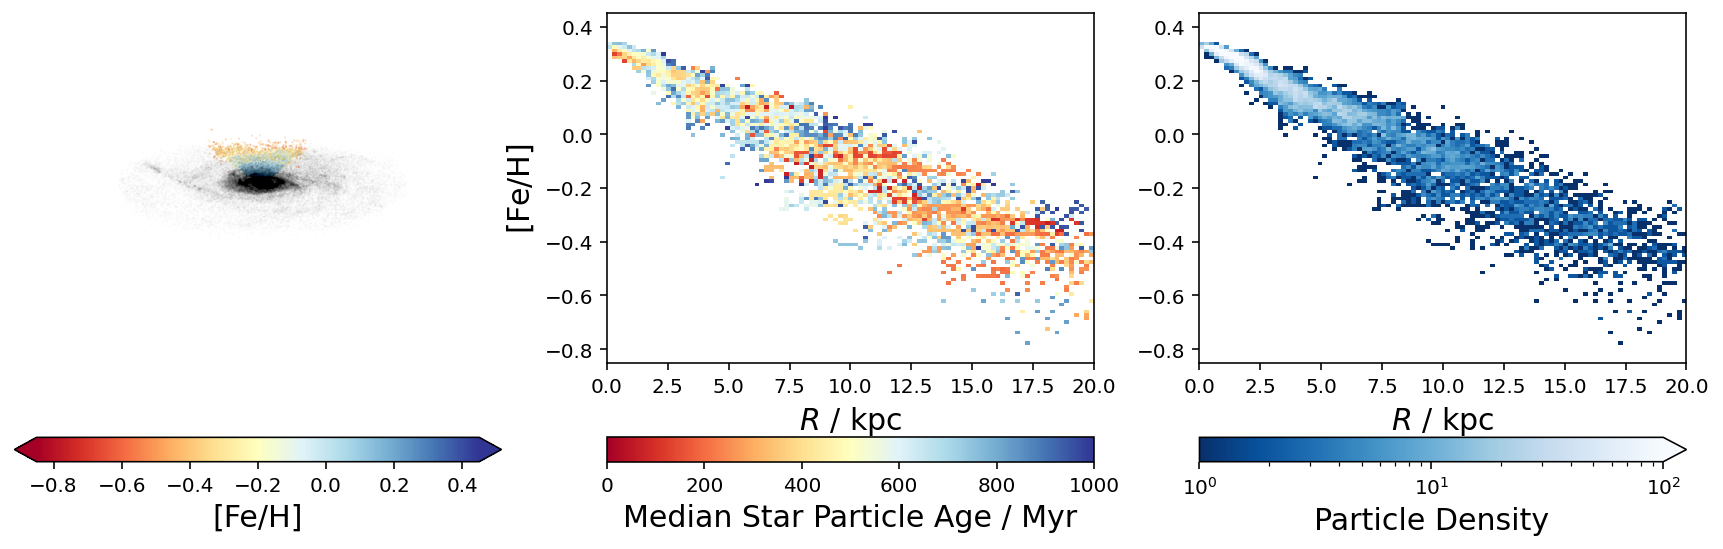

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310


In [ ]:
phi_angle = 45
R_max = 20
z_max = 5

maximum_age_myr = 1000.

for phi_index in np.arange(0,360,5):

    if phi_index%10==0:
        print(phi_index)
    
    phi_min = phi_index
    phi_max = phi_index + phi_angle
    if phi_max <= 360:
        within_phi = (
            (sim_stars['phi_angle'] >  phi_min) &
            (sim_stars['phi_angle'] <= phi_max)
        )
    if phi_max > 360:
        within_phi = (
            (sim_stars['phi_angle'] >  phi_min) |
            (sim_stars['phi_angle'] +360 <= phi_max)
        )

    sim_within_20kpc = (
        (sim_stars['R'] < R_max) &
        (sim_stars['age'] * 1000 < maximum_age_myr)
    )
    
    in_phi_range = (
        (sim_stars['R'] < R_max) &
        (sim_stars['age'] * 1000 < maximum_age_myr) &
        within_phi
    )

    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # Create left subplot (2/3 of the width)
    ax = fig.add_subplot(gs[0], projection='3d')

    s = ax.scatter(
        sim_stars['x'][sim_within_20kpc],
        sim_stars['y'][sim_within_20kpc],
        sim_stars['z'][sim_within_20kpc],
        c='k',zorder=1,
        s = 1,
        lw = 0,
        alpha = 0.01
    )
    s = ax.scatter(
        sim_stars['x'][in_phi_range],
        sim_stars['y'][in_phi_range],
        sim_stars['z'][in_phi_range],
        c = sim_stars['Fe_H'][in_phi_range],
        cmap = 'RdYlBu',
        vmin = -0.85, vmax = 0.45,
        s = 1, lw = 0, zorder=2
    )
    plt.colorbar(s, ax=ax, label='[Fe/H]',orientation='horizontal',extend='both')
    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_zlim(-15,15)

    # Remove grid and axes
    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(elev=20, azim=20)

    # Create right subplot (1/3 of the width)
    ax2 = fig.add_subplot(gs[1])

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['Fe_H'][in_phi_range],
        sim_stars['age'][in_phi_range]*1000, statistic='median',
        bins=(np.linspace(0,R_max,100),np.linspace(-0.85,0.45,100)))

    pcm = ax2.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = maximum_age_myr)
    plt.colorbar(pcm, ax=ax2, label='Median Star Particle Age / Myr',orientation='horizontal')
    ax2.set_xlabel(r'$R~/~\mathrm{kpc}$')
    ax2.set_ylabel(r'$\mathrm{[Fe/H]}$')

    # Create right subplot (1/3 of the width)
    ax2 = fig.add_subplot(gs[2])

    h = ax2.hist2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['Fe_H'][in_phi_range],
        bins=(np.linspace(0,R_max,100),np.linspace(-0.85,0.45,100)),
        cmin = 1, cmap='Blues_r', norm=LogNorm(vmin=1,vmax=100)
    )

    plt.colorbar(h[-1], ax=ax2, label='Particle Density',orientation='horizontal',extend='max')
    ax2.set_xlabel(r'$R~/~\mathrm{kpc}$')

    plt.tight_layout(w_pad=0)
    
    if phi_index < 10:
        st = '00'+str(phi_index)
    elif phi_index < 100:
        st = '0'+str(phi_index)
    else:
        st = str(phi_index)
    
    plt.savefig('figures/xyz_rfeh/xyz_rfeh_'+str(st)+'.png',dpi=200,bbox_inches='tight')
    if phi_index==0:
        plt.show()
    plt.close()

In [235]:
# make a GIF!
os.system('convert -delay 10 figures/xyz_rfeh/xyz_rfeh_*.png figures/xyz_rfeh.gif');

# Poggio et al. (2021)

In [ ]:
poggio2021_xvalues=np.load('data/Poggio_2021A&A...651A.104P_xvalues.npy')
poggio2021_yvalues=np.load('data/Poggio_2021A&A...651A.104P_yvalues.npy')
poggio2021_overdens_grid=np.load('data/Poggio_2021A&A...651A.104P_overdens_grid_locscale03.npy')

In [ ]:
f, gs = plt.subplots(1,3,figsize = (12,4.5))

ax = gs[0]
ax.text(0.04,0.95,panels[0]+' Milky Way (Poggio+21)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\odot~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\odot~/~\mathrm{kpc}$')

iniz=-1.18
fin=1.18
N_levels=50
levels=np.linspace(iniz,fin,N_levels)
cset1 = ax.contourf(xvalues, yvalues,overdens_grid.T, levels=levels, cmap='seismic',vmin=-1.18,vmax=1.18)
cbar=plt.colorbar(mappable=cset1,ax=ax,orientation="horizontal",ticks=[-1,-0.5, 0,  0.5, 1])
cbar.set_label('Overdensity')
ax.set_xlim([-5.5,5.5])
ax.set_ylim([-5.5,5.5])
ax.plot([0,0],[0,0],marker='P',c='white',markersize=7) # Sun's position

chosen_position = (-8,0)
radius = 5.5
age_cut = 1

ax = gs[1]
ax.text(0.04,0.95,panels[1]+' NIHAO MW-analogue (gas)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{GC}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{GC}~/~\mathrm{kpc}$')

within_radius = (
    (abs(sim_gas['x'] - chosen_position[0]) < radius) &
    (abs(sim_gas['y'] - chosen_position[1]) < radius) &
    (np.sqrt((sim_gas['x']-chosen_position[0])**2 + (sim_gas['y']-chosen_position[1])**2) < radius)
)

h = ax.hist2d(
    sim_gas['x'][within_radius],
    sim_gas['y'][within_radius],
    bins = 50, norm = LogNorm(),
    cmap = 'seismic', cmin = 1
)
plt.colorbar(h[-1], ax=ax, label='Gas density', orientation='horizontal')
ax.set_xlim([-5.5-8,5.5-8])
ax.set_ylim([-5.5,5.5])

ax = gs[2]
ax.text(0.04,0.95,panels[2]+' NIHAO MW-analogue (stars)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{GC}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{GC}~/~\mathrm{kpc}$')

within_radius = (
    (abs(sim_stars['x'] - chosen_position[0]) < radius) &
    (abs(sim_stars['y'] - chosen_position[1]) < radius) &
    (np.sqrt((sim_stars['x']-chosen_position[0])**2 + (sim_stars['y']-chosen_position[1])**2) < radius) &
    (sim_stars['age'] < age_cut)
)

h = ax.hist2d(
    sim_stars['x'][within_radius],
    sim_stars['y'][within_radius],
    bins = 50, norm = LogNorm(),
    cmap = 'plasma', cmin = 1
)
plt.colorbar(h[-1], ax=ax, label='Star density ($< '+str(age_cut)+'\,\mathrm{Gyr}$)', orientation='horizontal')
ax.set_xlim([-5.5-8,5.5-8])
ax.set_ylim([-5.5,5.5])

plt.tight_layout()
plt.savefig('figures/overdensities_mw_vs_nihao.png',dpi=300,bbox_inches='tight')